In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import suncalc

import dask.dataframe as dd
from pathlib import Path
import glob
import re

import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/bout")
sys.path.append("../src/tests")

In [3]:
import clustering as clstr
import bout.assembly as bt
import plot as bt_plt
import test_activity_metric_functions as test_actvt
import activity.subsampling as ss
import activity.activity_assembly as actvt
import pipeline
from core import SITE_NAMES, FREQUENCY_COLOR_MAPPINGS

from cli import get_file_paths
import pipeline

In [4]:
def plot_normalized_metrics_over_audio_seg(audio_features, spec_features, plot_dets, plot_bouts, bout_params, data_params):
    """
    Function to plot the spectrogram of a provided audio segment with overlayed detections
    """

    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 18})
    plt.title(f"BatDetect2 detections on {audio_features['plot_title']}", fontsize=22)
    # plt.specgram(audio_seg, NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmin=spec_features['vmin'])

    yellow_patch = patches.Patch(facecolor='yellow', edgecolor='k', label='Detections')

    legend_patches = [yellow_patch]
    ax = plt.gca()
    for i, row in plot_dets.iterrows():
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=2, edgecolor='k', facecolor='none', alpha=0.8)
        
        ax.add_patch(rect)

    legend_patches = []
    for group in bout_params.keys():
        if group != 'site_key':
            group_tag = group.split('_')[0]
            group_patch = patches.Patch(facecolor=FREQUENCY_COLOR_MAPPINGS[group_tag], edgecolor='k', label=f'BCI = {round(bout_params[group], 2)}ms')
            legend_patches += [group_patch]

    dc_tag = data_params['cur_dc_tag']
    cycle_length_in_mins = int(dc_tag.split('of')[1])
    time_on_in_mins = int(dc_tag.split('of')[0])
    data_params['index_time_block_in_secs'] = 5
    file_dt = dt.datetime.strptime(audio_features['file_path'].name, '%Y%m%d_%H%M%S.WAV')
    windows = pd.date_range(file_dt, file_dt+pd.Timedelta(minutes=30), freq=f'{cycle_length_in_mins}T', inclusive='left')

    if not(plot_bouts.empty):
        plot_bout_info(ax, audio_features, plot_bouts)
        bout_duration_per_cycle = actvt.get_bout_duration_per_cycle(plot_bouts.copy(), cycle_length_in_mins)
        bout_duration_per_cycle = bout_duration_per_cycle.reindex(windows, fill_value=0)
        btp_per_cycle = actvt.get_btp_per_time_on(bout_duration_per_cycle, data_params['time_on_in_secs'])
        plot_recording_periods_with_btp(ax, audio_features, data_params, np.round(btp_per_cycle,2))
    if not(plot_dets.empty):
        num_dets_per_cycle = actvt.get_number_of_detections_per_cycle(plot_dets.copy(), cycle_length_in_mins)
        num_dets_per_cycle = num_dets_per_cycle.reindex(windows, fill_value=0)
        callrate_per_cycle = actvt.get_metric_per_time_on(num_dets_per_cycle, time_on_in_mins)
        plot_recording_periods_with_callrate(ax, audio_features, data_params, np.round(callrate_per_cycle,2))
        blocks_per_cycle = actvt.get_activity_index_per_cycle(plot_dets.copy(), data_params)
        blocks_per_cycle = blocks_per_cycle.reindex(windows, fill_value=0)
        inds_percent_per_cycle = actvt.get_activity_index_per_time_on_index(blocks_per_cycle, data_params)
        plot_activity_index_time_blocks(ax, audio_features, data_params)
        plot_recording_periods_with_activity_inds_percent(ax, audio_features, data_params, np.round(inds_percent_per_cycle,2))

    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.gcf().autofmt_xdate()
    plt.legend(handles=legend_patches, fontsize=14, ncol=len(legend_patches), loc=1)

    plt.tight_layout()
    plt.show()


def plot_recording_periods_with_callrate(ax, audio_features, data_params, callrate_per_cycle):
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    dc_tag = data_params['cur_dc_tag']
    cycle_length = 60*(int(dc_tag.split('of')[1]))
    time_on = 60*(int(dc_tag.split('of')[0]))

    window_starts = np.arange(0, 1800, cycle_length)
    window_count = 0
    for window_start in window_starts:
        if (window_start < start+duration and window_start+time_on > start):
            if (window_start <= start):
                rect = patches.Rectangle((0, 0), (min(time_on, ((window_start+time_on)-start)))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor=None, alpha=0.1)
                text_loc = (min(time_on, ((window_start+time_on)-start)))/4
                plt.text(x=text_loc*fs/2, y=0.65, s=f"{callrate_per_cycle[window_count]} calls/min", color='k', weight='bold')
                window_count+=1
            elif (window_start+time_on) >= (start+duration):
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                        (min(time_on, (start+duration) - window_start))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor=None, alpha=0.1)
                text_loc =  (window_start-start) +(min(time_on, (start+duration) - window_start)/4)
                plt.text(x=text_loc*fs/2, y=0.65, s=f"{callrate_per_cycle[window_count]} calls/min", color='k', weight='bold')
                window_count+=1
            else:
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                            (time_on)*fs/2, fs/2, 
                                            linewidth=4, edgecolor='yellow', facecolor=None, alpha=0.1)
                text_loc =  (window_start-start) + (time_on/4)
                plt.text(x=text_loc*fs/2, y=0.65, s=f"{callrate_per_cycle[window_count]} calls/min", color='k', weight='bold')
                window_count+=1
            ax.add_patch(rect)

def plot_recording_periods_with_btp(ax, audio_features, data_params, btp_per_cycle):
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    dc_tag = data_params['cur_dc_tag']
    cycle_length = 60*(int(dc_tag.split('of')[1]))
    time_on = 60*(int(dc_tag.split('of')[0]))

    window_starts = np.arange(0, 1800, cycle_length)
    window_count = 0
    for window_start in window_starts:
        if (window_start < start+duration and window_start+time_on > start):
            if (window_start <= start):
                rect = patches.Rectangle((0, 0), (min(time_on, ((window_start+time_on)-start)))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor=None, alpha=0.1)
                text_loc = (min(time_on, ((window_start+time_on)-start)))/4
                plt.text(x=text_loc*fs/2, y=0.75, s=f"{btp_per_cycle[window_count]}% BTP", color='k', weight='bold')
                window_count+=1
            elif (window_start+time_on) >= (start+duration):
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                        (min(time_on, (start+duration) - window_start))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor=None, alpha=0.1)
                text_loc =  (window_start-start) + (min(time_on, (start+duration) - window_start)/4)
                plt.text(x=text_loc*fs/2, y=0.75, s=f"{btp_per_cycle[window_count]}% BTP", color='k', weight='bold')
                window_count+=1
            else:
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                            (time_on)*fs/2, fs/2, 
                                            linewidth=4, edgecolor='yellow', facecolor=None, alpha=0.1)
                text_loc =  (window_start-start) + (time_on/4)
                plt.text(x=text_loc*fs/2, y=0.75, s=f"{btp_per_cycle[window_count]}% BTP", color='k', weight='bold')
                window_count+=1
            ax.add_patch(rect)

def plot_recording_periods_with_activity_inds_percent(ax, audio_features, data_params, inds_per_cycle):
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    dc_tag = data_params['cur_dc_tag']
    cycle_length = 60*(int(dc_tag.split('of')[1]))
    time_on = 60*(int(dc_tag.split('of')[0]))

    window_starts = np.arange(0, 1800, cycle_length)
    window_count = 0
    for window_start in window_starts:
        if (window_start < start+duration and window_start+time_on > start):
            if (window_start <= start):
                rect = patches.Rectangle((0, 0), (min(time_on, ((window_start+time_on)-start)))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor='yellow', alpha=0.1)
                text_loc = (min(time_on, ((window_start+time_on)-start)))/4
                plt.text(x=text_loc*fs/2, y=0.55, s=f"{inds_per_cycle[window_count]}% AI", color='k', weight='bold')
                window_count+=1
            elif (window_start+time_on) >= (start+duration):
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                        (min(time_on, (start+duration) - window_start))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor='yellow', alpha=0.1)
                text_loc =  (window_start-start) +(min(time_on, (start+duration) - window_start)/4)
                plt.text(x=text_loc*fs/2, y=0.55, s=f"{inds_per_cycle[window_count]}% AI", color='k', weight='bold')
                window_count+=1
            else:
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                            (time_on)*fs/2, fs/2, 
                                            linewidth=4, edgecolor='yellow', facecolor='yellow', alpha=0.1)
                text_loc =  (window_start-start) + (time_on/4)
                plt.text(x=text_loc*fs/2, y=0.55, s=f"{inds_per_cycle[window_count]}% AI", color='k', weight='bold')
                window_count+=1
            ax.add_patch(rect)

def plot_raw_metrics_over_audio_seg(audio_features, spec_features, plot_dets, plot_bouts, bout_params, data_params):
    """
    Function to plot the spectrogram of a provided audio segment with overlayed detections
    """

    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 18})
    plt.title(f"BatDetect2 detections on {audio_features['plot_title']}", fontsize=22)
    # plt.specgram(audio_seg, NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmin=spec_features['vmin'])

    yellow_patch = patches.Patch(facecolor='yellow', edgecolor='k', label='Detections')

    legend_patches = [yellow_patch]
    ax = plt.gca()
    for i, row in plot_dets.iterrows():
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=2, edgecolor='k', facecolor='none', alpha=0.8)
        
        ax.add_patch(rect)

    legend_patches = []
    for group in bout_params.keys():
        if group != 'site_key':
            group_tag = group.split('_')[0]
            group_patch = patches.Patch(facecolor=FREQUENCY_COLOR_MAPPINGS[group_tag], edgecolor='k', label=f'BCI = {round(bout_params[group], 2)}ms')
            legend_patches += [group_patch]

    dc_tag = data_params['cur_dc_tag']
    cycle_length_in_mins = int(dc_tag.split('of')[1])
    data_params['index_time_block_in_secs'] = 5
    file_dt = dt.datetime.strptime(audio_features['file_path'].name, '%Y%m%d_%H%M%S.WAV')
    windows = pd.date_range(file_dt, file_dt+pd.Timedelta(minutes=30), freq=f'{cycle_length_in_mins}T', inclusive='left')

    if not(plot_bouts.empty):
        plot_bout_info(ax, audio_features, plot_bouts)
        bout_duration_per_cycle = actvt.get_bout_duration_per_cycle(plot_bouts.copy(), cycle_length_in_mins)
        bout_duration_per_cycle = bout_duration_per_cycle.reindex(windows, fill_value=0)
        plot_recording_periods_with_bout_duration(ax, audio_features, data_params, np.round(bout_duration_per_cycle,2))

    if not(plot_dets.empty):
        num_dets_per_cycle = actvt.get_number_of_detections_per_cycle(plot_dets.copy(), cycle_length_in_mins)
        num_dets_per_cycle = num_dets_per_cycle.reindex(windows, fill_value=0)
        plot_recording_periods_with_num_calls(ax, audio_features, data_params, num_dets_per_cycle)
        inds_per_cycle = actvt.get_activity_index_per_cycle(plot_dets.copy(), data_params)
        inds_per_cycle = inds_per_cycle.reindex(windows, fill_value=0)
        plot_activity_index_time_blocks(ax, audio_features, data_params)
        plot_recording_periods_with_activity_inds(ax, audio_features, data_params, inds_per_cycle)

    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.gcf().autofmt_xdate()
    plt.legend(handles=legend_patches, fontsize=14, ncol=len(legend_patches), loc=1)

    plt.tight_layout()
    plt.show()


def plot_recording_periods_with_num_calls(ax, audio_features, data_params, num_dets_per_cycle):
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    dc_tag = data_params['cur_dc_tag']
    cycle_length = 60*(int(dc_tag.split('of')[1]))
    time_on = 60*(int(dc_tag.split('of')[0]))

    window_starts = np.arange(0, 1800, cycle_length)
    window_count = 0
    for window_start in window_starts:
        if (window_start < start+duration and window_start+time_on > start):
            if (window_start <= start):
                rect = patches.Rectangle((0, 0), (min(time_on, ((window_start+time_on)-start)))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor=None, alpha=0.1)
                text_loc = (min(time_on, ((window_start+time_on)-start)))/4
                plt.text(x=text_loc*fs/2, y=0.65, s=f"{num_dets_per_cycle[window_count]} calls", color='k', weight='bold')
                window_count+=1
            elif (window_start+time_on) >= (start+duration):
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                        (min(time_on, (start+duration) - window_start))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor=None, alpha=0.1)
                text_loc =  (window_start-start) +(min(time_on, (start+duration) - window_start)/4)
                plt.text(x=text_loc*fs/2, y=0.65, s=f"{num_dets_per_cycle[window_count]} calls", color='k', weight='bold')
                window_count+=1
            else:
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                            (time_on)*fs/2, fs/2, 
                                            linewidth=4, edgecolor='yellow', facecolor=None, alpha=0.1)
                text_loc =  (window_start-start) + (time_on/4)
                plt.text(x=text_loc*fs/2, y=0.65, s=f"{num_dets_per_cycle[window_count]} calls", color='k', weight='bold')
                window_count+=1
            ax.add_patch(rect)

def plot_recording_periods_with_bout_duration(ax, audio_features, data_params, bout_duration_per_cycle):
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    dc_tag = data_params['cur_dc_tag']
    cycle_length = 60*(int(dc_tag.split('of')[1]))
    time_on = 60*(int(dc_tag.split('of')[0]))

    window_starts = np.arange(0, 1800, cycle_length)
    window_count = 0
    for window_start in window_starts:
        if (window_start < start+duration and window_start+time_on > start):
            if (window_start <= start):
                rect = patches.Rectangle((0, 0), (min(time_on, ((window_start+time_on)-start)))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor=None, alpha=0.1)
                text_loc = (min(time_on, ((window_start+time_on)-start)))/4
                plt.text(x=text_loc*fs/2, y=0.75, s=f"{bout_duration_per_cycle[window_count]}s of bouts", color='k', weight='bold')
                window_count+=1
            elif (window_start+time_on) >= (start+duration):
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                        (min(time_on, (start+duration) - window_start))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor=None, alpha=0.1)
                text_loc =  (window_start-start) + (min(time_on, (start+duration) - window_start)/4)
                plt.text(x=text_loc*fs/2, y=0.75, s=f"{bout_duration_per_cycle[window_count]}s of bouts", color='k', weight='bold')
                window_count+=1
            else:
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                            (time_on)*fs/2, fs/2, 
                                            linewidth=4, edgecolor='yellow', facecolor=None, alpha=0.1)
                text_loc =  (window_start-start) + (time_on/4)
                plt.text(x=text_loc*fs/2, y=0.75, s=f"{bout_duration_per_cycle[window_count]}s of bouts", color='k', weight='bold')
                window_count+=1
            ax.add_patch(rect)

def plot_recording_periods_with_activity_inds(ax, audio_features, data_params, inds_per_cycle):
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    dc_tag = data_params['cur_dc_tag']
    cycle_length = 60*(int(dc_tag.split('of')[1]))
    time_on = 60*(int(dc_tag.split('of')[0]))

    window_starts = np.arange(0, 1800, cycle_length)
    window_count = 0
    for window_start in window_starts:
        if (window_start < start+duration and window_start+time_on > start):
            if (window_start <= start):
                rect = patches.Rectangle((0, 0), (min(time_on, ((window_start+time_on)-start)))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor='yellow', alpha=0.1)
                text_loc = (min(time_on, ((window_start+time_on)-start)))/4
                plt.text(x=text_loc*fs/2, y=0.55, s=f"{inds_per_cycle[window_count]} AI", color='k', weight='bold')
                window_count+=1
            elif (window_start+time_on) >= (start+duration):
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                        (min(time_on, (start+duration) - window_start))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor='yellow', alpha=0.1)
                text_loc =  (window_start-start) +(min(time_on, (start+duration) - window_start)/4)
                plt.text(x=text_loc*fs/2, y=0.55, s=f"{inds_per_cycle[window_count]} AI", color='k', weight='bold')
                window_count+=1
            else:
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                            (time_on)*fs/2, fs/2, 
                                            linewidth=4, edgecolor='yellow', facecolor='yellow', alpha=0.1)
                text_loc =  (window_start-start) + (time_on/4)
                plt.text(x=text_loc*fs/2, y=0.55, s=f"{inds_per_cycle[window_count]} AI", color='k', weight='bold')
                window_count+=1
            ax.add_patch(rect)

def plot_bout_info(ax, audio_features, plot_bouts):
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    for i, row in plot_bouts.iterrows():
        if duration < 600:
            plt.text(x=(row['start_time'] - start + (row['bout_duration_in_secs']/5))*(fs/2), y=min((row['high_freq']+2000)/(fs/2), 9/10), 
                                s=f"{round(row['bout_duration_in_secs'], 2)}s", color='pink', weight='bold', fontsize=14)
            plt.text(x=(row['start_time'] - start + (row['bout_duration_in_secs']/5))*(fs/2), y=min((row['high_freq']+12000)/(fs/2), 9/10), 
                                s=f"{round(row['number_of_dets'], 2)} dets", color='pink', weight='bold', fontsize=14)
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['bout_duration_in_secs'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=2, edgecolor='k', facecolor='none', alpha=0.8)
        ax.add_patch(rect)

def plot_recording_periods(ax, audio_features, data_params):
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    dc_tag = data_params['cur_dc_tag']
    cycle_length = 60*(int(dc_tag.split('of')[1]))
    time_on = 60*(int(dc_tag.split('of')[0]))

    window_starts = np.arange(0, 1800, cycle_length)
    for window_start in window_starts:
        if (window_start <= start+duration and window_start+time_on > start):
            if (window_start <= start):
                rect = patches.Rectangle((0, 0), (min(time_on, ((window_start+time_on)-start)))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor='yellow', alpha=0.1)
            elif (window_start+time_on) >= (start+duration):
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                        (min(time_on, (start+duration) - window_start))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor='yellow', alpha=0.1)
            else:
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                            (time_on)*fs/2, fs/2, 
                                            linewidth=4, edgecolor='yellow', facecolor='yellow', alpha=0.1)
            ax.add_patch(rect)

def plot_activity_index_time_blocks(ax, audio_features, data_params):
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']
    index_time_block = data_params['index_time_block_in_secs']

    cycle_length = index_time_block
    time_on = index_time_block

    window_starts = np.arange(0, 1800, cycle_length)
    window_count = 0
    for window_start in window_starts:
        if (window_start < start+duration and window_start+time_on > start):
            if (window_start <= start):
                rect = patches.Rectangle((0, 0), (min(time_on, ((window_start+time_on)-start)))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='pink', facecolor=None, alpha=0.1)
                window_count+=1
            elif (window_start+time_on) >= (start+duration):
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                        (min(time_on, (start+duration) - window_start))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='pink', facecolor=None, alpha=0.1)
                window_count+=1
            else:
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                            (time_on)*fs/2, fs/2, 
                                            linewidth=4, edgecolor='pink', facecolor=None, alpha=0.1)
                window_count+=1
            ax.add_patch(rect)

In [5]:
site_key = 'Foliage'
freq_key = ''

data_params = dict()
data_params['site_tag'] = site_key
data_params['type_tag'] = freq_key
data_params['recording_start'] = '00:00'
data_params['recording_end'] = '16:00'
data_params['cur_dc_tag'] = '30of30'
data_params['cycle_length'] = int(data_params['cur_dc_tag'].split('of')[-1])
data_params['time_on'] = int(data_params['cur_dc_tag'].split('of')[0])
data_params['time_on_in_secs'] = 60*data_params['time_on']
file_paths = get_file_paths(data_params)

In [6]:
input_file1 = Path('../../Downloads/20220829_090000.WAV')


filename = input_file1.name
human_file_dets = pd.read_csv(f'../../Downloads/{filename.split(".")[0]}.txt', sep='\t')
human_file_dets = human_file_dets.loc[human_file_dets['View']=='Spectrogram 1']
human_file_dets.rename(columns={"Begin Time (s)": "start_time", 
                                "End Time (s)": "end_time",
                                "Low Freq (Hz)": "low_freq",
                                "High Freq (Hz)": "high_freq"}, inplace=True)
human_file_dets

,Selection,View,Channel,start_time,end_time,low_freq,high_freq,class,class_prob,det_prob,individual,event,input_file,Site name,Recover Folder,SD Card,confidency
1,39,Spectrogram 1,1,442.062659,442.086963,45428.571,55714.286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,40,Spectrogram 1,1,442.341670,442.353336,45642.857,53357.143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
5,41,Spectrogram 1,1,442.435970,442.449580,43928.571,53357.143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
7,42,Spectrogram 1,1,442.927885,442.937606,42000.000,50357.143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
9,43,Spectrogram 1,1,443.119401,443.127178,43071.429,50785.714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,35,Spectrogram 1,1,1561.694500,1561.701200,47812.000,62170.000,Pipistrellus pipistrellus,0.552,0.575,-1.0,Echolocation,/mnt/ubna_data_02/recover-20220828/UBNA_009/20...,Foliage,recover-20220828,9.0,NaN
215,36,Spectrogram 1,1,1561.904500,1561.914600,44375.000,62079.000,Pipistrellus pipistrellus,0.291,0.500,-1.0,Echolocation,/mnt/ubna_data_02/recover-20220828/UBNA_009/20...,Foliage,recover-20220828,9.0,NaN
217,37,Spectrogram 1,1,1563.160500,1563.165800,44375.000,61153.000,Pipistrellus pipistrellus,0.442,0.574,-1.0,Echolocation,/mnt/ubna_data_02/recover-20220828/UBNA_009/20...,Foliage,recover-20220828,9.0,NaN
219,38,Spectrogram 1,1,1610.826500,1610.832600,47812.000,62341.000,Pipistrellus pipistrellus,0.440,0.534,-1.0,Echolocation,/mnt/ubna_data_02/recover-20220828/UBNA_009/20...,Foliage,recover-20220828,9.0,NaN


In [7]:
file_dts = pd.to_datetime(human_file_dets['input_file'], format='%Y%m%d_%H%M%S', exact=False).ffill().bfill()

anchor_start_times = file_dts + pd.to_timedelta(human_file_dets['start_time'].values.astype('float64'), unit='S')
anchor_end_times = file_dts + pd.to_timedelta(human_file_dets['end_time'].values.astype('float64'), unit='S') 
human_file_dets.insert(0, 'call_end_time', anchor_end_times)
human_file_dets.insert(0, 'call_start_time', anchor_start_times)
human_file_dets.insert(0, 'ref_time', anchor_start_times)
human_file_dets = human_file_dets.sort_values(by='call_start_time')
hf_human_dets = human_file_dets.loc[(human_file_dets['low_freq']>=30000)]

In [8]:
location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', low_memory=False, index_col=0)
bout_params = bt.get_bout_params_from_location(location_df, data_params)

In [9]:
hf_human_dets

,ref_time,call_start_time,call_end_time,Selection,View,Channel,start_time,end_time,low_freq,high_freq,class,class_prob,det_prob,individual,event,input_file,Site name,Recover Folder,SD Card,confidency
1,2022-08-29 09:07:22.062659235,2022-08-29 09:07:22.062659235,2022-08-29 09:07:22.086963323,39,Spectrogram 1,1,442.062659,442.086963,45428.571,55714.286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
11,2022-08-29 09:07:22.251258955,2022-08-29 09:07:22.251258955,2022-08-29 09:07:22.262924916,44,Spectrogram 1,1,442.251259,442.262925,41571.429,58928.571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,2022-08-29 09:07:22.341670161,2022-08-29 09:07:22.341670161,2022-08-29 09:07:22.353336123,40,Spectrogram 1,1,442.341670,442.353336,45642.857,53357.143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
5,2022-08-29 09:07:22.435970021,2022-08-29 09:07:22.435970021,2022-08-29 09:07:22.449580310,41,Spectrogram 1,1,442.435970,442.449580,43928.571,53357.143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
145,2022-08-29 09:07:22.538500000,2022-08-29 09:07:22.538500000,2022-08-29 09:07:22.544400000,1,Spectrogram 1,1,442.538500,442.544400,46093.000,54116.000,Pipistrellus pipistrellus,0.521,0.543,-1.0,Echolocation,/mnt/ubna_data_02/recover-20220828/UBNA_009/20...,Foliage,recover-20220828,9.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2022-08-29 09:26:02.142614167,2022-08-29 09:26:02.142614167,2022-08-29 09:26:02.157196619,108,Spectrogram 1,1,1562.142614,1562.157197,39500.000,58250.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
143,2022-08-29 09:26:02.370100426,2022-08-29 09:26:02.370100426,2022-08-29 09:26:02.376905571,110,Spectrogram 1,1,1562.370100,1562.376906,42769.231,50769.231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
221,2022-08-29 09:26:02.497453845,2022-08-29 09:26:02.497453845,2022-08-29 09:26:02.510091971,111,Spectrogram 1,1,1562.497454,1562.510092,38769.231,52307.692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
217,2022-08-29 09:26:03.160500000,2022-08-29 09:26:03.160500000,2022-08-29 09:26:03.165800000,37,Spectrogram 1,1,1563.160500,1563.165800,44375.000,61153.000,Pipistrellus pipistrellus,0.442,0.574,-1.0,Echolocation,/mnt/ubna_data_02/recover-20220828/UBNA_009/20...,Foliage,recover-20220828,9.0,NaN


In [10]:
file_path = input_file1
filename = file_path.name
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 0
duration = 1800
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 60 # hide anything below -rm_dB dB

pipeline_params = dict()
pipeline_params['assemble_location_summary'] = True
pipeline_params["read_csv"] = False
pipeline_params['use_threshold_to_group'] = False
pipeline_params['use_kmeans_to_group'] = True

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration
audio_features['plot_title'] = f"{filename} (Mila\'s File) all calls"

spec_features = dict()
spec_features['vmin'] = vmin
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'

dc_applied_df = ss.simulate_dutycycle_on_detections(hf_human_dets.copy(), data_params)
plot_dets = dc_applied_df.loc[np.logical_and(dc_applied_df['start_time'] >= start, dc_applied_df['end_time'] <= (start+duration))]

plot_dets.insert(0, 'freq_group', ['HF']*plot_dets.shape[0])
bout_metrics = bt.generate_bout_metrics_for_location_and_freq(plot_dets, data_params, bout_params)
plot_bouts = bout_metrics.loc[np.logical_and(bout_metrics['start_time'] >= start, bout_metrics['end_time'] <= (start+duration))]

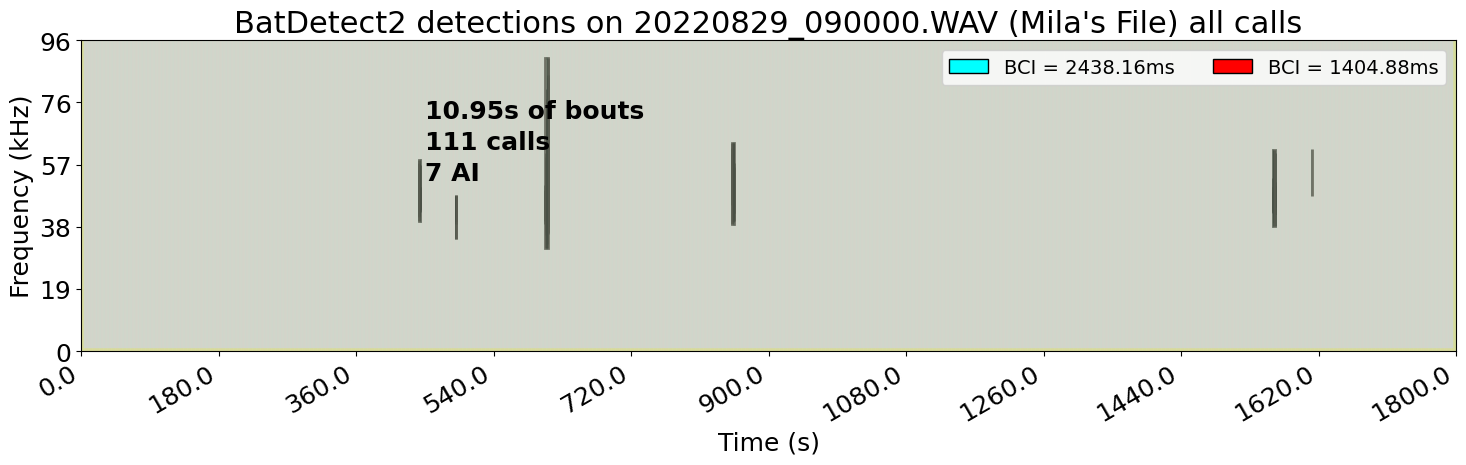

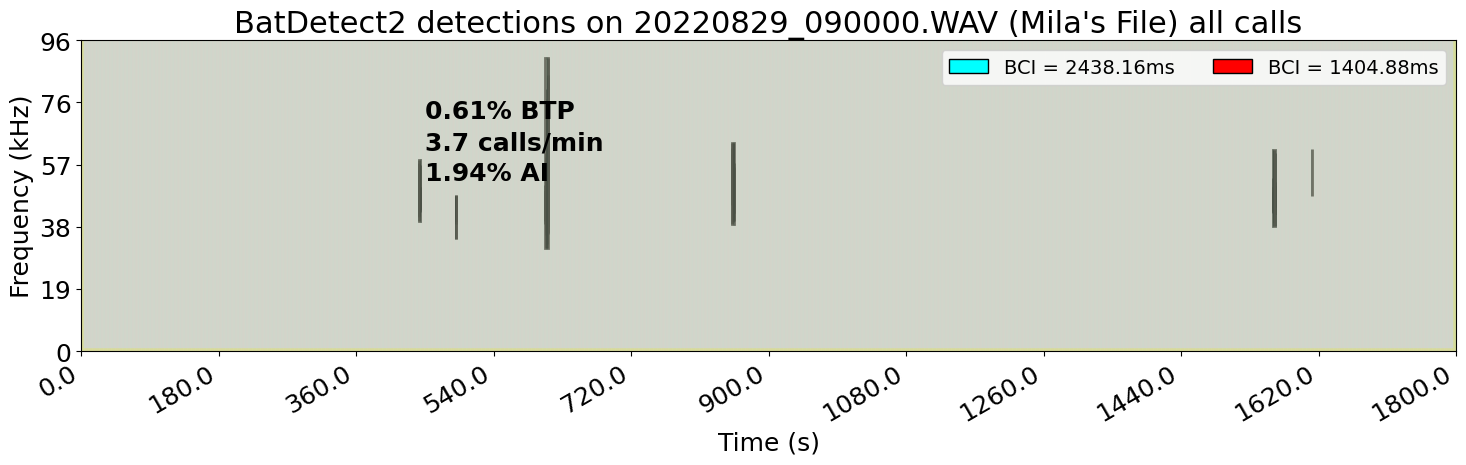

In [11]:
plot_raw_metrics_over_audio_seg(audio_features, spec_features, plot_dets, plot_bouts, bout_params,  data_params)
plot_normalized_metrics_over_audio_seg(audio_features, spec_features, plot_dets, plot_bouts, bout_params,  data_params)

In [12]:
file_path = input_file1
filename = file_path.name
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 0
duration = 1800
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 60 # hide anything below -rm_dB dB

pipeline_params = dict()
pipeline_params['assemble_location_summary'] = True
pipeline_params["read_csv"] = False
pipeline_params['use_threshold_to_group'] = False
pipeline_params['use_kmeans_to_group'] = True

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration
audio_features['plot_title'] = Path(f"{filename} (Mila\'s File) 50% calls randomly reduced")

spec_features = dict()
spec_features['vmin'] = vmin
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'

dc_applied_df = ss.simulate_dutycycle_on_detections(hf_human_dets.copy(), data_params)
dc_applied_df_reduced = dc_applied_df.sample(frac=0.5).sort_values(by='start_time')
plot_dets = dc_applied_df_reduced.loc[np.logical_and(dc_applied_df_reduced['start_time'] >= start, dc_applied_df_reduced['end_time'] <= (start+duration))]

plot_dets.insert(0, 'freq_group', ['HF']*plot_dets.shape[0])
bout_metrics = bt.generate_bout_metrics_for_location_and_freq(plot_dets, data_params, bout_params)
plot_bouts = bout_metrics.loc[np.logical_and(bout_metrics['start_time'] >= start, bout_metrics['end_time'] <= (start+duration))]

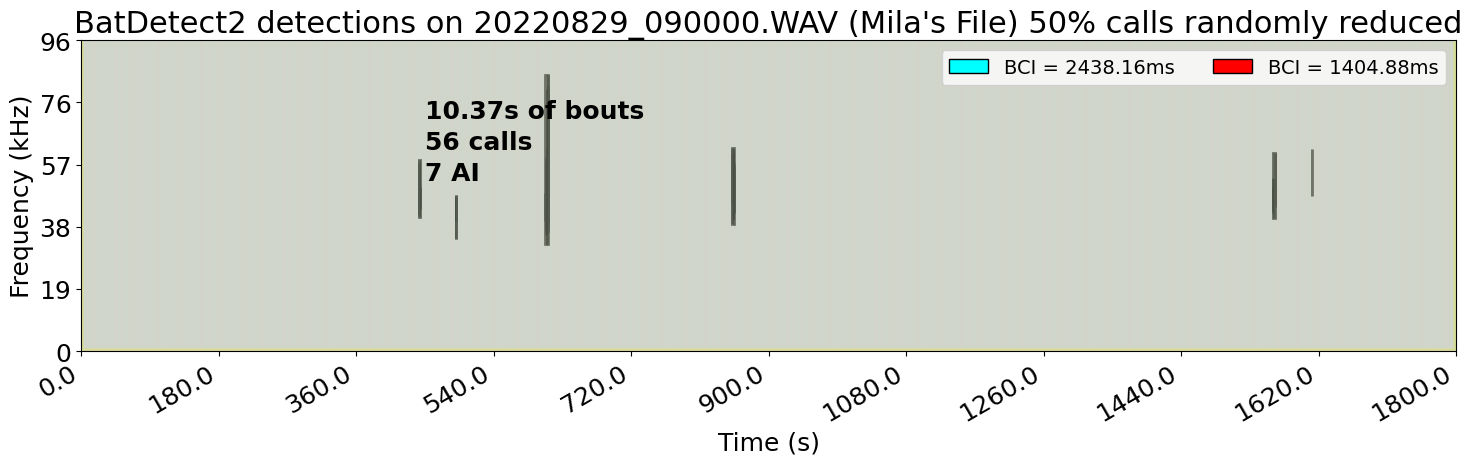

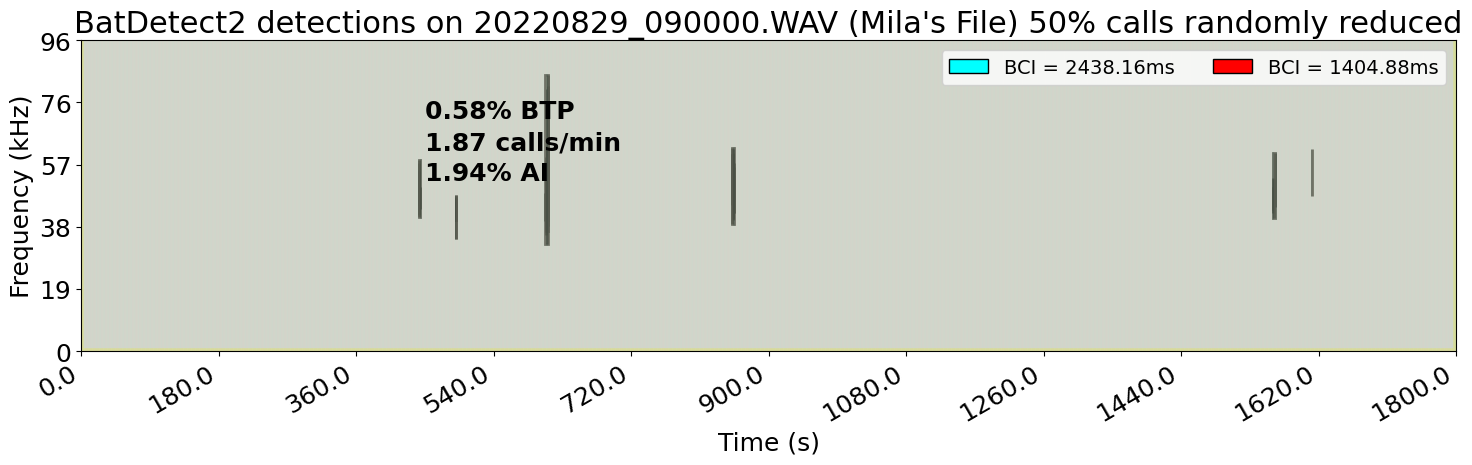

In [13]:
plot_raw_metrics_over_audio_seg(audio_features, spec_features, plot_dets, plot_bouts, bout_params,  data_params)
plot_normalized_metrics_over_audio_seg(audio_features, spec_features, plot_dets, plot_bouts, bout_params,  data_params)

In [14]:
file_path = input_file1
filename = file_path.name
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 0
duration = 1800
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 60 # hide anything below -rm_dB dB

pipeline_params = dict()
pipeline_params['assemble_location_summary'] = True
pipeline_params["read_csv"] = False
pipeline_params['use_threshold_to_group'] = False
pipeline_params['use_kmeans_to_group'] = True

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration
audio_features['plot_title'] = Path(f"{filename} (Mila\'s File) 80% calls randomly reduced")

spec_features = dict()
spec_features['vmin'] = vmin
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'

dc_applied_df = ss.simulate_dutycycle_on_detections(hf_human_dets.copy(), data_params)
dc_applied_df_reduced = dc_applied_df.sample(frac=0.2).sort_values(by='start_time')
plot_dets = dc_applied_df_reduced.loc[np.logical_and(dc_applied_df_reduced['start_time'] >= start, dc_applied_df_reduced['end_time'] <= (start+duration))]

plot_dets.insert(0, 'freq_group', ['HF']*plot_dets.shape[0])
bout_metrics = bt.generate_bout_metrics_for_location_and_freq(plot_dets, data_params, bout_params)
plot_bouts = bout_metrics.loc[np.logical_and(bout_metrics['start_time'] >= start, bout_metrics['end_time'] <= (start+duration))]

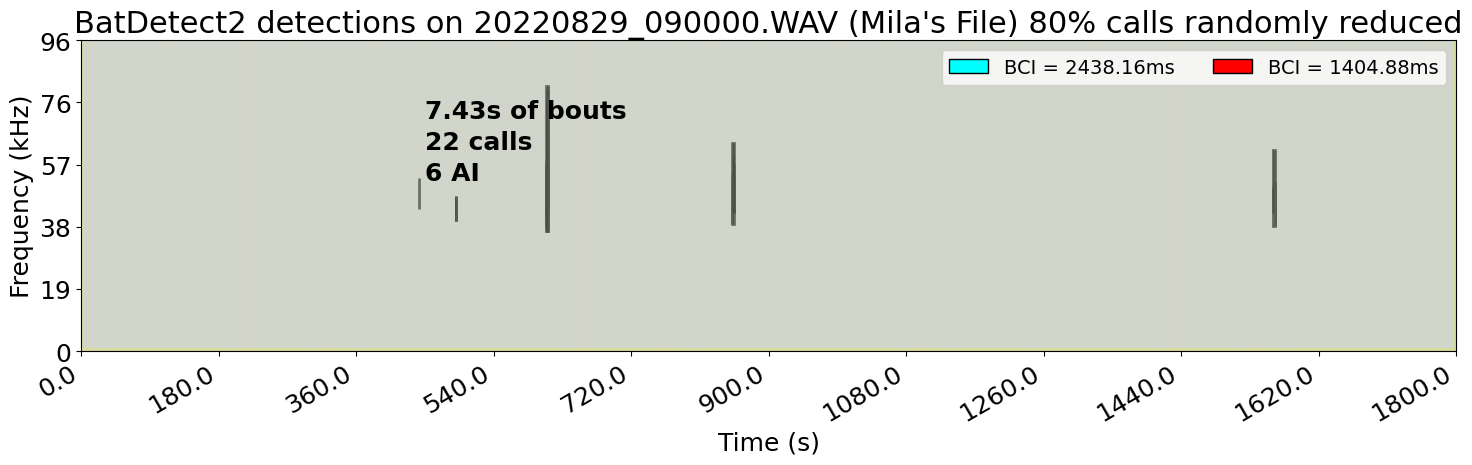

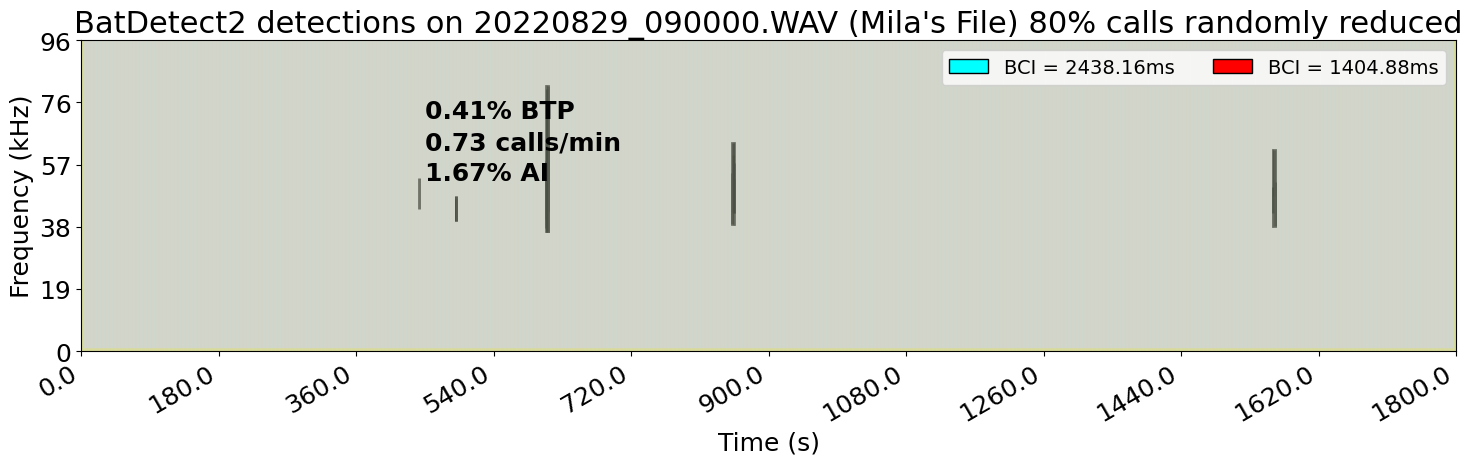

In [15]:
plot_raw_metrics_over_audio_seg(audio_features, spec_features, plot_dets, plot_bouts, bout_params,  data_params)
plot_normalized_metrics_over_audio_seg(audio_features, spec_features, plot_dets, plot_bouts, bout_params,  data_params)

In [16]:
ai_percents = []
call_rates = []
bt_percents = []
dc_applied_df = ss.simulate_dutycycle_on_detections(hf_human_dets.copy(), data_params)

fracs = np.arange(1.0,0,-0.1)
for p in fracs:
    dc_applied_df_reduced = dc_applied_df.sample(frac=p).sort_values(by='start_time')
    plot_dets = dc_applied_df_reduced.loc[np.logical_and(dc_applied_df_reduced['start_time'] >= start, dc_applied_df_reduced['end_time'] <= (start+duration))]

    plot_dets.insert(0, 'freq_group', ['HF']*plot_dets.shape[0])
    bout_metrics = bt.generate_bout_metrics_for_location_and_freq(plot_dets, data_params, bout_params)
    plot_bouts = bout_metrics.loc[np.logical_and(bout_metrics['start_time'] >= start, bout_metrics['end_time'] <= (start+duration))]
    file_dt = dt.datetime.strptime(audio_features['file_path'].name, '%Y%m%d_%H%M%S.WAV')
    windows = pd.date_range(file_dt, file_dt+pd.Timedelta(minutes=30), freq=f'{data_params["cycle_length"]}T', inclusive='left')

    bout_dur_per_cycle = actvt.get_bout_duration_per_cycle(plot_bouts.copy(), data_params['cycle_length'])
    bout_dur_per_cycle = bout_dur_per_cycle.reindex(windows, fill_value=0)
    btp_per_cycle = actvt.get_btp_per_time_on(bout_dur_per_cycle, data_params['time_on_in_secs'])

    num_dets_per_cycle = actvt.get_number_of_detections_per_cycle(plot_dets.copy(), data_params['cycle_length'])
    num_dets_per_cycle = num_dets_per_cycle.reindex(windows, fill_value=0)
    callrate_per_cycle = actvt.get_metric_per_time_on(num_dets_per_cycle, data_params['cycle_length'])

    blocks_per_cycle = actvt.get_activity_index_per_cycle(plot_dets.copy(), data_params)
    blocks_per_cycle = blocks_per_cycle.reindex(windows, fill_value=0)
    inds_percent_per_cycle = actvt.get_activity_index_per_time_on_index(blocks_per_cycle, data_params)

    bt_percents += [btp_per_cycle]
    call_rates += [callrate_per_cycle]
    ai_percents += [inds_percent_per_cycle.values]

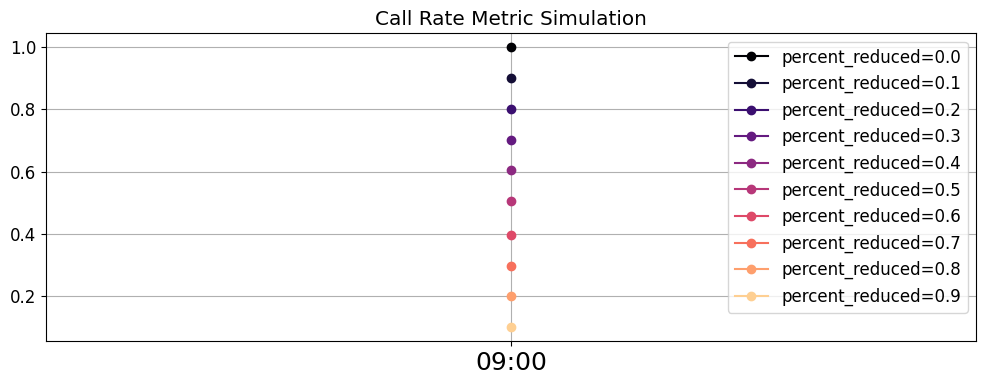

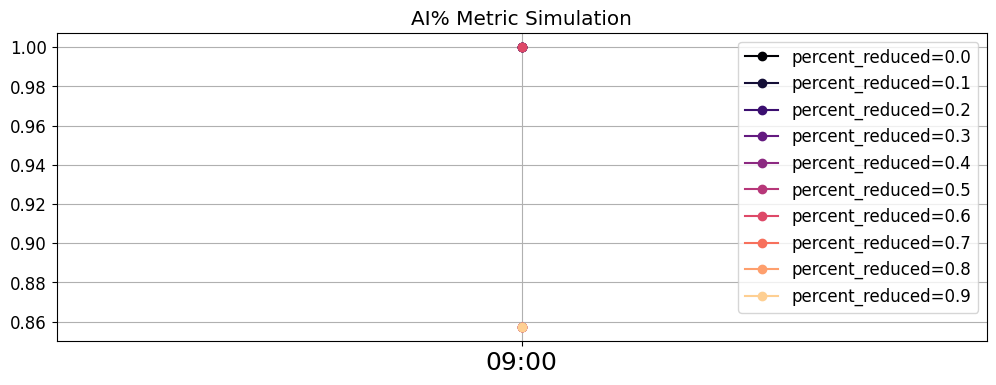

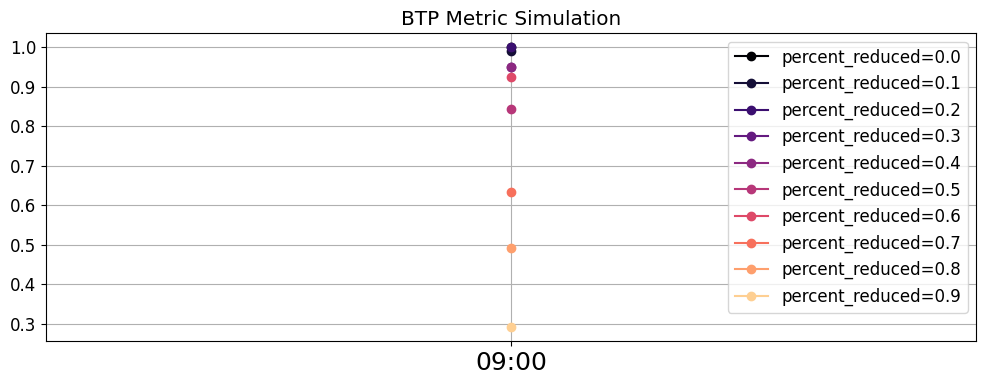

In [17]:
plt_fracs = np.tile(np.arange(0, np.array(call_rates).shape[1]), (np.array(call_rates).shape[0],1)).T
plt_callrates = np.array(call_rates).T
plt_callrates = plt_callrates/plt_callrates[0,0]

plt.figure(figsize=(12,4))
plt.rcParams.update({'font.size':12})
plt.title('Call Rate Metric Simulation')
cm = plt.cm.magma(np.arange(0, np.array(call_rates).shape[0])/np.array(call_rates).shape[0])
ax = plt.gca()
ax.set_prop_cycle('color', list(cm))
plt.plot(plt_fracs, plt_callrates, marker='o')
plt.grid(which='both')
plt.legend([f'percent_reduced={round(1-p,2)}' for p in fracs],fontsize=12,loc=1)
# plt.yticks(np.arange(0,np.array(call_rates).max()+10,10),fontsize=18)
plt.xticks(np.arange(0,len(callrate_per_cycle.index)),(callrate_per_cycle.index).strftime('%H:%M'),fontsize=18)
plt.show()


plt_ai_percents = np.array(ai_percents).T
plt_ai_percents = plt_ai_percents/plt_ai_percents[0,0]
plt.figure(figsize=(12,4))
plt.rcParams.update({'font.size':12})
plt.title('AI% Metric Simulation')
cm = plt.cm.magma(np.arange(0, np.array(call_rates).shape[0])/np.array(call_rates).shape[0])
ax = plt.gca()
ax.set_prop_cycle('color', list(cm))
plt.plot(plt_fracs, plt_ai_percents, marker='o')
plt.grid(which='both')
plt.legend([f'percent_reduced={round(1-p,2)}' for p in fracs],fontsize=12,loc=1)
# plt.yticks(np.arange(0,np.array(ai_percents).max()+10,10),fontsize=18)
plt.xticks(np.arange(0,len(inds_percent_per_cycle.index)),(inds_percent_per_cycle.index).strftime('%H:%M'),fontsize=18)
plt.show()

plt_bt_percents = np.array(bt_percents).T
plt_bt_percents = plt_bt_percents/plt_bt_percents[0,0]
plt.figure(figsize=(12,4))
plt.rcParams.update({'font.size':12})
plt.title('BTP Metric Simulation')
cm = plt.cm.magma(np.arange(0, np.array(call_rates).shape[0])/np.array(call_rates).shape[0])
ax = plt.gca()
ax.set_prop_cycle('color', list(cm))
plt.plot(plt_fracs, plt_bt_percents, marker='o')
plt.grid(which='both')
plt.legend([f'percent_reduced={round(1-p,2)}' for p in fracs],fontsize=12,loc=1)
# plt.yticks(np.arange(0,np.array(bt_percents).max()+10,10),fontsize=18)
plt.xticks(np.arange(0,len(btp_per_cycle.index)),(btp_per_cycle.index).strftime('%H:%M'),fontsize=18)
plt.show()

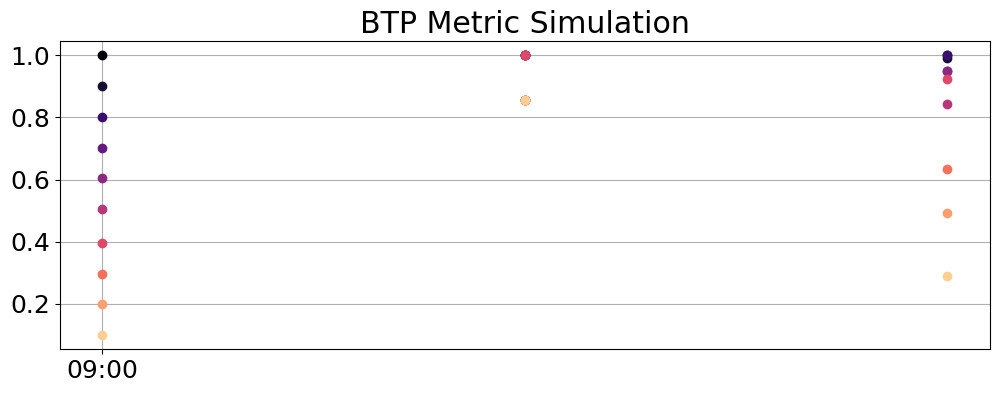

In [21]:
plt_fracs = np.tile(np.arange(0, np.array(call_rates).shape[1]), (np.array(call_rates).shape[0],1)).T
plt_callrates = np.array(call_rates).T
plt_callrates = plt_callrates/plt_callrates[0,0]

plt.figure(figsize=(12,4))
plt.rcParams.update({'font.size':18})
plt.title('Call Rate Metric Simulation')
cm = plt.cm.magma(np.arange(0, np.array(call_rates).shape[0])/np.array(call_rates).shape[0])
ax = plt.gca()
ax.set_prop_cycle('color', list(cm))
plt.plot(plt_fracs, plt_callrates, marker='o')
plt.grid(which='both')
# plt.legend([f'percent_reduced={round(1-p,2)}' for p in fracs],fontsize=12,loc=1)
# plt.yticks(np.arange(0,np.array(call_rates).max()+10,10),fontsize=18)
plt.xticks(np.arange(0,len(callrate_per_cycle.index)),(callrate_per_cycle.index).strftime('%H:%M'),fontsize=18)
# plt.show()


plt_ai_percents = np.array(ai_percents).T
plt_ai_percents = plt_ai_percents/plt_ai_percents[0,0]
# plt.figure(figsize=(12,4))
plt.rcParams.update({'font.size':18})
plt.title('AI% Metric Simulation')
cm = plt.cm.magma(np.arange(0, np.array(call_rates).shape[0])/np.array(call_rates).shape[0])
ax = plt.gca()
ax.set_prop_cycle('color', list(cm))
plt.plot(plt_fracs+1, plt_ai_percents, marker='o')
plt.grid(which='both')
# plt.legend([f'percent_reduced={round(1-p,2)}' for p in fracs],fontsize=12,loc=1)
# plt.yticks(np.arange(0,np.array(ai_percents).max()+10,10),fontsize=18)
plt.xticks(np.arange(0,len(inds_percent_per_cycle.index)),(inds_percent_per_cycle.index).strftime('%H:%M'),fontsize=18)
# plt.show()

plt_bt_percents = np.array(bt_percents).T
plt_bt_percents = plt_bt_percents/plt_bt_percents[0,0]
# plt.figure(figsize=(12,4))
plt.rcParams.update({'font.size':18})
plt.title('BTP Metric Simulation')
cm = plt.cm.magma(np.arange(0, np.array(call_rates).shape[0])/np.array(call_rates).shape[0])
ax = plt.gca()
ax.set_prop_cycle('color', list(cm))
plt.plot(plt_fracs+2, plt_bt_percents, marker='o')
plt.grid(which='both')
# plt.legend([f'percent_reduced={round(1-p,2)}' for p in fracs],fontsize=12,loc=1)
# plt.yticks(np.arange(0,np.array(bt_percents).max()+10,10),fontsize=18)
plt.xticks(np.arange(0,len(btp_per_cycle.index)),(btp_per_cycle.index).strftime('%H:%M'),fontsize=18)
plt.show()

In [20]:
plt_ai_percents

array([[1.        , 1.        , 1.        , 0.85714286, 0.85714286,
        1.        , 1.        , 0.85714286, 0.85714286, 0.85714286]])